# 4.8.2 バッチ正規化 - PyTorch (MNIST)

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optimizers
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import datasets
import torchvision.transforms as transforms

In [0]:
class DNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.l1 = nn.Linear(input_dim, hidden_dim)
        self.b1 = nn.BatchNorm1d(hidden_dim)
        self.a1 = nn.ReLU()
        self.d1 = nn.Dropout(0.5)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.b2 = nn.BatchNorm1d(hidden_dim)
        self.a2 = nn.ReLU()
        self.d2 = nn.Dropout(0.5)
        self.l3 = nn.Linear(hidden_dim, hidden_dim)
        self.b3 = nn.BatchNorm1d(hidden_dim)
        self.a3 = nn.ReLU()
        self.d3 = nn.Dropout(0.5)
        self.l4 = nn.Linear(hidden_dim, output_dim)

        self.layers = [self.l1, self.b1, self.a1, self.d1,
                       self.l2, self.b2, self.a2, self.d2,
                       self.l3, self.b3, self.a3, self.d3,
                       self.l4]

        for layer in self.layers:
            if type(layer) == nn.Linear:
                nn.init.kaiming_normal_(layer.weight)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

class EarlyStopping:
    '''
    早期終了 (early stopping)
    '''
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def __call__(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

In [0]:
np.random.seed(123)
torch.manual_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# 1. データの準備
root = os.path.join('~', '.torch', 'mnist')
transform = transforms.Compose([transforms.ToTensor(),
                                lambda x: x.view(-1)])
mnist_train = datasets.MNIST(root=root,
                              download=True,
                              train=True,
                              transform=transform)
mnist_test = datasets.MNIST(root=root,
                            download=True,
                            train=False,
                            transform=transform)

n_samples = len(mnist_train)
n_train = int(n_samples * 0.8)
n_val = n_samples - n_train

mnist_train, mnist_val = \
    random_split(mnist_train, [n_train, n_val])

train_dataloader = DataLoader(mnist_train,
                              batch_size=100,
                              shuffle=True)
val_dataloader = DataLoader(mnist_val,
                            batch_size=100,
                            shuffle=False)
test_dataloader = DataLoader(mnist_test,
                              batch_size=100,
                              shuffle=False)


Extracting /root/.torch/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /root/.torch/mnist/MNIST/raw



Extracting /root/.torch/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.torch/mnist/MNIST/raw



Extracting /root/.torch/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.torch/mnist/MNIST/raw



Extracting /root/.torch/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.torch/mnist/MNIST/raw
Processing...
Done!


In [0]:
# 2. モデルの構築
model = DNN(784, 200, 10).to(device)

In [0]:
# 3. モデルの学習
criterion = nn.CrossEntropyLoss()
optimizer = optimizers.Adam(model.parameters(),
                            lr=0.001,
                            betas=(0.9, 0.999), amsgrad=True)


In [0]:
def compute_loss(t, y):
    return criterion(y, t)

def train_step(x, t):
    model.train()
    preds = model(x)
    loss = compute_loss(t, preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss, preds

def val_step(x, t):
    model.eval()
    preds = model(x)
    loss = criterion(preds, t)

    return loss, preds

In [9]:
epochs = 1000
hist = {'loss': [], 'accuracy': [],
        'val_loss': [], 'val_accuracy': []}
es = EarlyStopping(patience=5, verbose=1)

for epoch in range(epochs):
    train_loss = 0.
    train_acc = 0.
    val_loss = 0.
    val_acc = 0.

    for (x, t) in train_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = train_step(x, t)
        train_loss += loss.item()
        train_acc += \
            accuracy_score(t.tolist(),
                            preds.argmax(dim=-1).tolist())

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    for (x, t) in val_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = val_step(x, t)
        val_loss += loss.item()
        val_acc += \
            accuracy_score(t.tolist(),
                            preds.argmax(dim=-1).tolist())

    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)

    hist['loss'].append(train_loss)
    hist['accuracy'].append(train_acc)
    hist['val_loss'].append(val_loss)
    hist['val_accuracy'].append(val_acc)

    print('epoch: {}, loss: {:.3}, acc: {:.3f}'
          ', val_loss: {:.3}, val_acc: {:.3f}'.format(
              epoch+1,
              train_loss,
              train_acc,
              val_loss,
              val_acc
          ))

    if es(val_loss):
        break


epoch: 1, loss: 0.815, acc: 0.739, val_loss: 0.234, val_acc: 0.928
epoch: 2, loss: 0.384, acc: 0.885, val_loss: 0.18, val_acc: 0.944
epoch: 3, loss: 0.316, acc: 0.907, val_loss: 0.149, val_acc: 0.954
epoch: 4, loss: 0.268, acc: 0.921, val_loss: 0.132, val_acc: 0.959
epoch: 5, loss: 0.238, acc: 0.930, val_loss: 0.123, val_acc: 0.962
epoch: 6, loss: 0.208, acc: 0.938, val_loss: 0.113, val_acc: 0.966
epoch: 7, loss: 0.197, acc: 0.942, val_loss: 0.105, val_acc: 0.967
epoch: 8, loss: 0.186, acc: 0.945, val_loss: 0.097, val_acc: 0.969
epoch: 9, loss: 0.174, acc: 0.949, val_loss: 0.0964, val_acc: 0.968
epoch: 10, loss: 0.165, acc: 0.951, val_loss: 0.09, val_acc: 0.972
epoch: 11, loss: 0.157, acc: 0.953, val_loss: 0.0891, val_acc: 0.973
epoch: 12, loss: 0.149, acc: 0.956, val_loss: 0.0825, val_acc: 0.974
epoch: 13, loss: 0.141, acc: 0.958, val_loss: 0.0834, val_acc: 0.973
epoch: 14, loss: 0.133, acc: 0.961, val_loss: 0.0815, val_acc: 0.974
epoch: 15, loss: 0.131, acc: 0.960, val_loss: 0.0787, 

In [0]:
# 4. モデルの評価

# 検証データの誤差の可視化
loss = hist['loss']
val_loss = hist['val_loss']

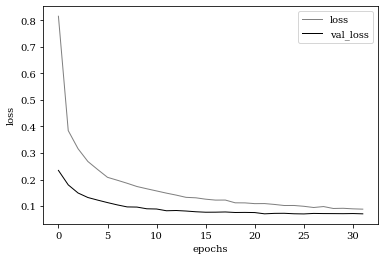

In [11]:
fig = plt.figure()
plt.rc('font', family='serif')
plt.plot(range(len(loss)), loss,
          color='gray', linewidth=1,
          label='loss')
plt.plot(range(len(val_loss)), val_loss,
          color='black', linewidth=1,
          label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
# plt.savefig('output.jpg')
plt.show()

In [12]:
# テストデータの評価
def test_step(x, t):
    return val_step(x, t)

test_loss = 0.
test_acc = 0.

for (x, t) in test_dataloader:
    x, t = x.to(device), t.to(device)
    loss, preds = test_step(x, t)
    test_loss += loss.item()
    test_acc += \
        accuracy_score(t.tolist(),
                        preds.argmax(dim=-1).tolist())

test_loss /= len(test_dataloader)
test_acc /= len(test_dataloader)
print('test_loss: {:.3f}, test_acc: {:.3f}'.format(
    test_loss,
    test_acc
))

test_loss: 0.067, test_acc: 0.982
